# Домашняя работа

Будем работать с датасетом подержанных машин https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

Задача - построить прогноз цены машины по ее данным (год выпуска, пробег, расход, размер двигателя, тип коробки передач и тд). 

## Easy

Построить прогноз по одной марке машин при помощи решающих деревьев, взять только числовые признаки. В качестве метрики взять `r2_score`. Оценить важность признаков, проинтерпретировать модель.

In [1]:
import os
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV # быстрее Grid, но менее точный 

import seaborn as sns

In [2]:
base_path = "../data/cars/"

In [3]:
df1 = pd.read_csv(f'{base_path}audi.csv')
df1.isnull().sum().sum()

0

In [4]:
cols = df1.columns
print(df1.shape, cols, sep='\n')

(10668, 9)
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')


In [5]:
df1 = df1.select_dtypes(include='number')
numerical = df1.columns
categorical = list(set(cols) - set(numerical))
print(categorical)  # из важного (эмпирически) дропнули тип модели

['transmission', 'fuelType', 'model']


In [6]:
rg = DecisionTreeRegressor()

In [7]:
X = df1.drop(columns='price')
y = df1['price']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [9]:
rg.fit(x_train, y_train)

DecisionTreeRegressor()

In [10]:
y_pred = rg.predict(x_test)
r2score = r2_score(y_pred, y_test)
r2score

0.9075514187540915

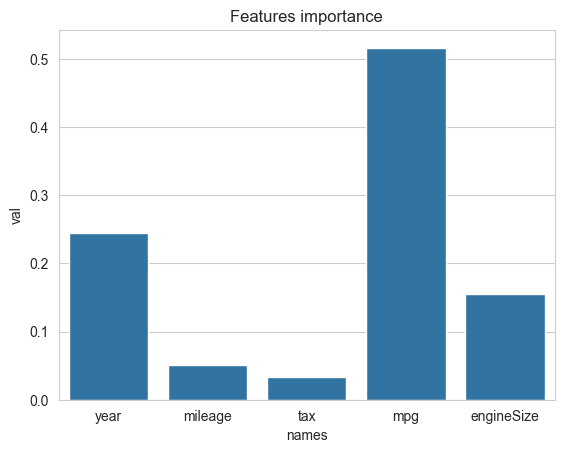

In [11]:
res = pd.DataFrame({"names": rg.feature_names_in_, "val": rg.feature_importances_})
graph = sns.barplot(x=res.names, y=res.val)
graph.set_title("Features importance");

Имеет среднее значение год регистрации (насколько машина старая), объем бака. Что удивительно, примерно вдвое более важным оказался удельный расход бензина, и совершенно неважен налог (да и пробег не особо). Можно попробовать обучить модельку без него.

## Normal

Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.

In [12]:
df = pd.DataFrame()
df.shape

(0, 0)

In [13]:
for path in os.listdir(base_path):
    if 'unclean' not in path:
        data = pd.read_csv(f'{base_path}{path}')
        df = pd.concat([df, data])

In [14]:
print(df.shape, df.columns.tolist(), df.isna().sum(axis=0), sep='\n')

(108540, 10)
['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'tax(£)']
model                0
year                 0
price                0
transmission         0
mileage              0
fuelType             0
tax              14213
mpg               9353
engineSize           0
tax(£)          103680
dtype: int64


### Поработаем с выбросами

In [15]:
taxna = df.tax.isna()
tax2 = 'tax(£)'
tax2na = df[tax2].isna()
samples = df[(~taxna) & (~tax2na)]  #.filter(regex="tax*")
samples.shape[0]

0

In [16]:
df.loc[taxna, 'tax'] = df[taxna]['tax(£)']
df.tax.isna().sum()

9353

In [17]:
df.drop(columns=tax2, inplace=True)
df.shape

(108540, 9)

In [18]:
taxna = df.tax.isna()
(
            df.mpg.isna() != taxna).sum()  # как видим, теперь нули только в каких-то одинаковых семплах, видимо, в одной из моделек

0

In [19]:
nuls_models = df[taxna].model.value_counts()  # на самом деле, в двух
nuls_models

model
Focus      5454
C Class    3899
Name: count, dtype: int64

### И с категориальными

In [20]:
for col in categorical:
    print(df[col].value_counts(), end="\n=========\n")

transmission
Manual       61308
Semi-Auto    24903
Automatic    22319
Other           10
Name: count, dtype: int64
fuelType
Petrol      59875
Diesel      45177
Hybrid       3229
Other         253
Electric        6
Name: count, dtype: int64
model
 Focus      10042
 C Class     7646
 Fiesta      6557
 Golf        4863
 Corsa       3441
            ...  
180             1
230             1
220             1
200             1
 Accent         1
Name: count, Length: 195, dtype: int64


In [21]:
params = {
    "splitter": ["best", "random"],
    "max_depth": [None, *list(range(2, 20 + 1, 2))],
    "min_samples_split": [2, 5, 0.02],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.001, 0.005, 0.01, 0.02]
}

In [22]:
search = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), params, verbose=2, n_iter=100, random_state=42)
search.fit(x_train, y_train)
search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ccp_alpha=0.02, max_depth=10, max_features=sqrt, min_samples_split=0.02, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.02, max_depth=10, max_features=sqrt, min_samples_split=0.02, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.02, max_depth=10, max_features=sqrt, min_samples_split=0.02, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.02, max_depth=10, max_features=sqrt, min_samples_split=0.02, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.02, max_depth=10, max_features=sqrt, min_samples_split=0.02, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.01, max_depth=14, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.01, max_depth=14, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END ccp_alpha=0.01, max_depth=14, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END ccp_alpha

DecisionTreeRegressor(ccp_alpha=0.005, max_depth=14, min_samples_split=5,
                      random_state=42)

In [23]:
model = search.best_estimator_
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2score = r2_score(y_pred, y_test)
r2score # как видим, скоры очень близкие к изначальным

0.9263683254530819